# Introduction to Different Peak Fitting in Python

So far you have been introduced to the python programming language, working with arrays, importing data simple curve fitting, and doing simple peak fiitings . In this tutorial we are going to apply those skills to different peak fitting data to improve accuracy of fitting and uncertainty value .

After this tutorial you should be able to:

    Fit data with multiple Gaussian distributions
    Fit data with Lorentzian Function
    Combine Gaussian and Lorentzian into pseudo Voigt analysis
    Deduce each methods uncertainty
Using Gaussian and Lorentzian distributions to fit the dataset is reasonable for data with little noise undergoing multiple separate component distributions.

We'll be using the same imports as our previous tutorials with new important additions, math from which we import pi,sin. 

In [103]:
import numpy as np
import csv
import os
import matplotlib.pyplot as plt
import pandas as pd
import math
import scipy
from scipy.optimize import curve_fit
from math import pi,sin

# Importing the Data
For this tutorial I already have a datafile of xrd data. This datafile is stacked .csv where the first column is the value of 2-theta and subsequent columns are diffracted intensity for a variety of samples.
To import the data we're going to define a function "csv_to_np" which will use the read_csv function built into pandas to pull the data, and then convert it to a numpy array since we're already familiar with working with those.

First, given that It's worthwhile to make a function that will convert our data with respect to Q go ahead and use the two_to_q function built to pull the data, and takes in an array of 2-theta values and a X-ray wavelength 𝜆, and returns an array of Q values.

In [104]:
def csv_to_np(filename):
    data = pd.read_csv(filename)
    return(np.array(data))

perov = csv_to_np('D1_MAPBIBr2_Xraydeg.csv')

In [105]:
def two_to_q(two_theta, wave):
    #two_theta is a 1D array of two_theta angles
    #wave is the X-ray energy in angstroms
    rad_theta = two_theta/2*np.pi/180
    q = 4*np.pi*np.sin(rad_theta)/wave
    return q

In [106]:
q=two_to_q(perov[:,2],0.9763)
Q= q.tolist()

Go ahead and plot our data. Remember to plot the first column (index 0) of our 2D array (our 2-theta values) against the X-ray diffraction intensities (the values in any other column).

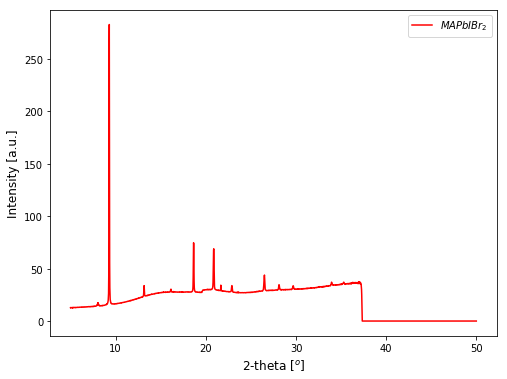

In [107]:
plt.figure(figsize=(8,6)) #make plot larger
plt.plot(perov[:,0],perov[:,1],'r-', label='$MAPbIBr_2$') #plot two-theta versus XRD intesntiy
plt.xlabel('2-theta [$^o$]',size=12) #Define x-axis label
plt.ylabel('Intensity [a.u.]',size=12)#Define y-axis label
plt.legend(loc="upper right")#Put legend in upper left hand corner

# Trimming Data
Lets go ahead an trim out data with set limits,so we can then reference those when calling some segment of our array.


In [108]:
def find_nearest(array, target):
    array = np.asarray(array) # In case the input is not an array type
    idx = (np.abs(array - target)).argmin() # Finds the index of the value closest to the target
    return idx


#We use our new function to find the index of real value closest to our desired limit

q_1 = 0.98 # This will be the lower limit for Q we'll consider
q_2 = 1.10 # This will be our upper limit - ideally there is only one peak between these values

limit1 = Q.index(find_nearest(q, q_1))
limit2 = Q.index(find_nearest(q, q_2))
q_sub = q[limit1:limit2]
perov_sub = perov[limit1:limit2,1:]
plt.plot(q_sub,perov_sub[:,-1])

ValueError: 12 is not in list

In [109]:

q_sub = q[limit1:limit2] # We'll reduce the domain of Q
perov_sub = perov[limit1:limit2,1:-1]

q_linear = np.hstack((q_sub[0:10], q_sub[-11:-1])) #I'm taking the starting and ending values
perov_linear = np.hstack((perov_sub[0:10,0], perov_sub[-11:-1,0])) #We'll use these to fit a straight line
slope, intercept = np.polyfit(q_linear, perov_linear, 1) #Do linear fit
back = slope*q_sub+intercept #Create background array of the form Background = Ax+B
#print (back)

#plt.plot(q_sub,perov_sub[:,1], 'r-',label='$MAPbIBr_2$')# plot minus background 
#Let's begin by getting our data ready to analyze
perov_fit = perov_sub[:,0]-back #We'll begin by subtracting the background we calculated for this piece of data

#Now let's define a function we'll want to fit to - this is analagous to the "straight-line-model" from tutorial 03
#We'll call our function gaussian and it will calculate the expression described above
def gaussian(x, a, b, c): 
    return a*np.exp(-(x - b)**2/(2*c**2))

#We'll also give an initial guess for our fits based off of a visual interpretaion of our data
p0 = [45, 2.4, 2]

#Use scipy.optimize.curve_fit to fit our desired data
popt, pcov = curve_fit(gaussian, q_sub, perov_fit, p0)

#To confirm our fits it's always nice to plot our model versus our data.
plt.figure(figsize=(8,6)) #make plot larger
plt.plot(q_sub,perov_fit,'r-', label='$MAPbIBr_2$') #plot subfield of data
plt.plot(q_sub,gaussian(q_sub, *popt),'b--', label='Model') #plot best fit
plt.xlabel('Q [$\AA^{-1}$]',size=12) #Define x-axis label
plt.ylabel('Intensity [a.u.]',size=12)#Define y-axis label
plt.legend(loc="upper right")#Put legend in upper left hand corner



TypeError: expected non-empty vector for x

# Subrtacting Background 

In [110]:
#remove background
size = perov_sub.shape
print (size)
q_bins = size[0]
#print (q_bins)
num_frames = size[1]
slope = np.zeros((num_frames,1))
intercept = np.zeros((num_frames,1))
back = np.zeros((q_bins,num_frames))
int_correct = np.zeros((q_bins,num_frames))

(0, 29)


In [111]:
for j in range(num_frames): 
    slope[j] = ((np.mean(perov_sub[-10:-1,j])-np.mean(perov_sub[0:10,j]))/(np.mean(q[limit2-10:limit2])-np.mean(q[limit1:limit1+10])))
    b[j]=perov_sub[0,j]-slope[j]*q_sub[0]
    back[:,j] = [slope[j]*element+b[j] for element in q_sub]
    int_correct[:,j] = perov_sub[:,j]-np.array(back[:,j])

plt.plot(np.array(q_sub),int_correct)

IndexError: index 0 is out of bounds for axis 0 with size 0

# Iterative Guassian fitting
Unlike in tutorial 4, where you learned how to fit the experimental data to a gaussian fit. Most likely youll find data that is hard to analyze with just one gaussian fit indicating the material in undergoing compenent distriubuting chnages.

Below youll learn how simple and better multigaussian fits are for materials undergoing changes.

Rememebr that our idelaized model is a guassian peak, which is described by the following expression:

$$f(x)=ae^{\frac{-(x-b)^2}{2c^2}}$$

Where $a$ is the height of the peak, $b$ is the peak's center, and $c$ is the standard deviation which impacts the width of the peak.

In [112]:
#Let's begin by getting our data ready to analyze
perov_fit = perov_sub[:,0]-back #We'll begin by subtracting the background we calculated for this piece of data

#Now let's define a function we'll want to fit to - this is analagous to the "straight-line-model" from tutorial 03
#We'll call our function gaussian and it will calculate the expression described above
def gaussian(x, a, b, c): 
    return a*np.exp(-(x - b)**2/(2*c**2))

#We'll also give an initial guess for our fits based off of a visual interpretaion of our data
p0 = [250, 1, 0.2]

#Use scipy.optimize.curve_fit to fit our desired data
popt, pcov = curve_fit(gaussian, q_sub, perov_fit, p0)



ValueError: operands could not be broadcast together with shapes (0,) (0,29) 

In [ ]:
#Remember to confirm our fits by plotting our model versus our data.
plt.figure(figsize=(8,6)) #make plot larger
plt.plot(q_sub,perov_fit,'r-', label='$MAPbIBr_2$') #plot subfield of data
plt.plot(q_sub,gaussian(q_sub, *popt),'b--', label='Model') #plot best fit
plt.xlabel('Q [$\AA^{-1}$]',size=12) #Define x-axis label
plt.ylabel('Intensity [a.u.]',size=12)#Define y-axis label
plt.legend(loc="upper right")#Put legend in upper left hand corner

In [114]:
#Youll see the fit isnt accurately depiciting our data
#adding another or two gaussian fits can help more accurately plot our model versus our data
i = 2#number of fits 
j = 16#number of frames 
#6 parameters in total depiciting a,b,c for two different peaks you detect
p0 =  [20, 2.08, 0.02, 10,2.08]
plt.plot(np.array(q_sub), int_correct[:,j],color='black')
if i == 2:
    popt, pcov = curve_fit(two_gaussians, np.array(q_sub), int_correct[:,j], p0[0:6])
    #plt.plot(np.array(q_sub), two_gaussians(np.array(q_sub),*popt))
    pars_1 = popt[0:3]
    pars_2 = popt[3:6]
    gauss_peak_1 = gaussian(np.array(q_sub), *pars_1)
    gauss_peak_2 = gaussian(np.array(q_sub), *pars_2)
    plt.plot(np.array(q_sub), gauss_peak_1, color='red')
    plt.plot(np.array(q_sub),gauss_peak_2,color='blue') 
    plt.plot(np.array(q_sub), gauss_peak_1+gauss_peak_2,color='green')
    print('lattice spacing:', [4*math.pi/popt[1], 4*math.pi/popt[4]])
    intensity_1[j] = popt[0]
    lattice_1[j] = 4*math.pi/popt[1] 
    intensity_2[j] = popt[3]
    lattice_2[j] = 4*math.pi/popt[4]
#i==3 will apply if you want three different fits
if i == 3:
    popt, pcov = curve_fit(three_gaussians, np.array(q_sub), int_correct[:,j], p0)
    #plt.plot(np.array(q_sub), three_gaussians(np.array(q_sub),*popt))
    pars_1 = popt[0:3]
    pars_2 = popt[3:6]
    pars_3 = popt[6:9]
    gauss_peak_1 = gaussian(np.array(q_sub), *pars_1)
    gauss_peak_2 = gaussian(np.array(q_sub), *pars_2)
    gauss_peak_3 = gaussian(np.array(q_sub), *pars_3)
    plt.plot(np.array(q_sub), gauss_peak_1, color='magenta')
    plt.plot(np.array(q_sub),gauss_peak_2,color='blue') 
    plt.plot(np.array(q_sub),gauss_peak_3,color='green')
    plt.plot(np.array(q_sub),gauss_peak_3+gauss_peak_1+gauss_peak_2,color='red',linestyle='dashed')
    print('lattice spacing:', [4*math.pi/popt[1], 4*math.pi/popt[4],4*math.pi/popt[7]])
    intensity_1[j] = popt[0]
    lattice_1[j] = 4*math.pi/popt[1] 
    intensity_2[j] = popt[3]
    lattice_2[j] = 4*math.pi/popt[4]
    intensity_2[j] = popt[6]
    lattice_3[j] = 4*math.pi/popt[7]
#i==1,if you only want one fit
else: 
    popt, pcov = curve_fit(gaussian, np.array(q_sub), int_correct[:,j], p0[0:3])
    plt.plot(np.array(q_sub), gaussian(np.array(q_sub),*popt))
    print('lattice spacing:', [4*math.pi/popt[1]])
    intensity_1[j] = popt[0]
    lattice_1[j] = 4*math.pi/popt[1] 

print(popt)
plt.xlabel('Q')
plt.ylabel('Intensity')

# Lorentzian Function
Now that youve seen how much more qualitavely accurate multi guassian peak fitting is well go thorugh another idelaized model, Lorentizian peak:
                            
                          f(x;A,μ,σ)=Aπ[σ(x−μ)2+σ2]
 Like Guassian, $a$ is the height of the peak, $b$ is the peak's center, and $c$ is the standard deviation which impacts the width of the peak. In addition, parameters $fwhm$ and height are included as constraints to report full width at half maximum and maximum peak height, respectively.

In [115]:
#Let's begin by getting our data ready to analyze
perov_fit = perov_sub[:,0]-back #We'll begin by subtracting the background we calculated for this piece of data

#Now let's define a function we'll want to fit to - this is analagous to the "straight-line-model" from tutorial 03
#We'll call our function gaussian and it will calculate the expression described above
def gaussian(x, a, b, c): 
    return a*np.exp(-(x - b)**2/(2*c**2))

#We'll also give an initial guess for our fits based off of a visual interpretaion of our data
p0 = [250, 1, 0.2]

#Use scipy.optimize.curve_fit to fit our desired data
popt, pcov = curve_fit(gaussian, q_sub, perov_fit, p0)

ValueError: operands could not be broadcast together with shapes (0,) (0,29) 